## Objective

This notebook performs customer segmentation using K-Means clustering.
Based on prior data cleaning, EDA, and correlation-based feature selection,
customers are grouped according to their behavioral patterns.

The objective is not only to identify statistically meaningful clusters,
but also to create segments that are interpretable and actionable
for CRM and business decision-making.

In [14]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/processed/customer_clean.csv")
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,908.354652,1.000000,231.35,0.00,231.35,944.183414,1.000000,0.000000,0.857143,0.142857,3,7,1000.0,161.975360,930.115009,0.0,7
1,744.083484,1.000000,1096.98,589.48,507.50,174.714236,1.000000,0.500000,0.600000,0.200000,4,14,5000.0,1873.388189,148.294074,0.1,10
2,738.067431,1.000000,752.97,752.97,0.00,0.000000,0.666667,0.666667,0.000000,0.000000,0,11,2500.0,1393.051729,282.663936,0.0,12
3,333.085021,0.636364,980.00,980.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1000.0,1485.205378,163.396716,0.0,12
4,3559.634883,1.000000,7654.81,6984.29,670.52,0.000000,0.666667,0.666667,0.333333,0.000000,0,45,7000.0,2785.055072,783.737906,0.0,12


### Feature Selection

Based on exploratory data analysis and correlation analysis, the following
features are selected to represent distinct dimensions of customer behavior:

- Spending intensity
- Usage frequency
- Cash advance reliance
- Account scale
- Payment discipline

In [15]:
final_features = [
    "BALANCE",
    "PURCHASES",
    "PURCHASES_FREQUENCY",
    "CASH_ADVANCE",
    "CREDIT_LIMIT",
    "PRC_FULL_PAYMENT"
]

X = df[final_features]
X.head()

,BALANCE,PURCHASES,PURCHASES_FREQUENCY,CASH_ADVANCE,CREDIT_LIMIT,PRC_FULL_PAYMENT
0,908.354652,231.35,1.000000,944.183414,1000.0,0.0
1,744.083484,1096.98,1.000000,174.714236,5000.0,0.1
2,738.067431,752.97,0.666667,0.000000,2500.0,0.0
3,333.085021,980.00,0.083333,0.000000,1000.0,0.0
4,3559.634883,7654.81,0.666667,0.000000,7000.0,0.0


### Feature Scaling

K-Means clustering is distance-based and sensitive to feature scale.
Therefore, standardization is applied so that all features contribute
equally to the clustering process.

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Determining the Optimal Number of Clusters

To determine an appropriate number of clusters (k), multiple evaluation
approaches are considered, including the Elbow Method and Silhouette Analysis.
These methods provide complementary perspectives on cluster compactness,
separation, and interpretability.

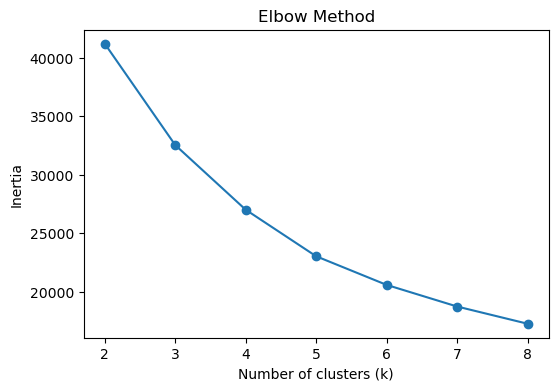

In [17]:
inertia = []

K = range(2, 9)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertia, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

The elbow curve shows a steep decrease in inertia between k = 2 and k = 4.
Beyond k = 4, the marginal reduction in within-cluster variance becomes
progressively smaller, suggesting diminishing returns from adding more clusters.

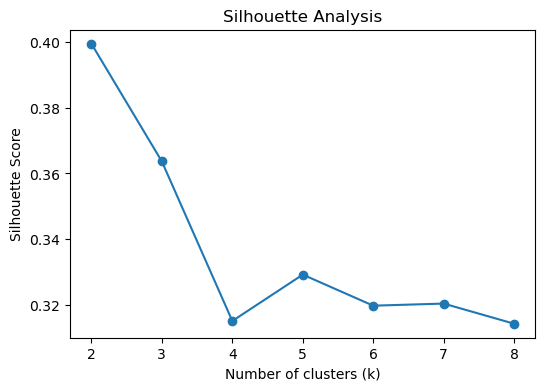

In [18]:
from sklearn.metrics import silhouette_score

sil_scores = []

for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(6,4))
plt.plot(range(2,9), sil_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()

Silhouette analysis shows the highest score at k = 2, indicating that the data
can be broadly separated into two well-defined groups. However, such a coarse
segmentation lacks sufficient granularity for actionable customer insights.

As k increases, the silhouette score gradually decreases, which is expected
when capturing more nuanced behavioral patterns.

### Final Choice of Number of Clusters

While k = 2 yields the highest silhouette score, it produces overly broad
segments that limit business interpretability. The Elbow Method indicates
that improvements beyond k = 4 are marginal, and silhouette scores at k = 4
remain at an acceptable level.

Considering both quantitative evaluation metrics and the need for interpretable
and actionable customer segments, k = 4 is selected as a balanced and practical
choice for customer segmentation.

### K-Means Clustering

Using the selected number of clusters (k = 4), K-Means clustering is applied
to segment customers based on their standardized behavioral features.

In [19]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_scaled)

df["cluster"].value_counts()

cluster
2    3702
3    2816
0    1279
1    1003
Name: count, dtype: int64

## Cluster Profiling

To understand the behavioral characteristics of each customer segment,
we compute the average value of selected features within each cluster.
This allows us to compare clusters across key behavioral dimensions.

In [20]:
cluster_profile = (
    df.groupby("cluster")[final_features]
    .mean()
    .round(2)
)

cluster_profile

,BALANCE,PURCHASES,PURCHASES_FREQUENCY,CASH_ADVANCE,CREDIT_LIMIT,PRC_FULL_PAYMENT
cluster,,,,,,
0,190.12,1886.11,0.79,98.34,5122.05,0.81
1,5897.49,1650.59,0.41,4481.15,9942.53,0.02
2,1147.16,210.84,0.13,818.15,3138.91,0.04
3,1183.40,1406.11,0.86,329.78,4049.92,0.06


To facilitate comparison across clusters, feature values are normalized
between 0 and 1 at the cluster level.

In [21]:
cluster_profile_norm = (
    cluster_profile - cluster_profile.min()
) / (cluster_profile.max() - cluster_profile.min())

cluster_profile_norm.round(2)

,BALANCE,PURCHASES,PURCHASES_FREQUENCY,CASH_ADVANCE,CREDIT_LIMIT,PRC_FULL_PAYMENT
cluster,,,,,,
0,0.00,1.00,0.90,0.00,0.29,1.00
1,1.00,0.86,0.38,1.00,1.00,0.00
2,0.17,0.00,0.00,0.16,0.00,0.03
3,0.17,0.71,1.00,0.05,0.13,0.05


In [22]:
import os

# ensure output directory exists
os.makedirs("../outputs/tables", exist_ok=True)

# save segmentation result
df.to_csv("../outputs/tables/customer_with_clusters.csv", index=False)

## Cluster Interpretation

Based on the cluster profiles, four distinct customer segments can be identified,
each characterized by different spending behaviors, usage patterns, and payment discipline.

## Cluster Interpretation

Based on the cluster profiles, four distinct customer segments are identified.
Each cluster represents a different combination of spending behavior, usage
frequency, cash advance reliance, and payment discipline.

---

### Cluster 0 — Low Engagement Customers

**Characteristics:**
- Low overall balance and spending
- Low purchase frequency
- Minimal cash advance usage
- Moderate to high full payment ratio

**Interpretation:**
This segment represents low-engagement customers who use their credit cards
infrequently and maintain relatively low balances. They pose limited credit
risk but also contribute limited revenue.

---

### Cluster 1 — High-Value Active Spenders

**Characteristics:**
- High purchase amounts and high purchase frequency
- Moderate balances relative to credit limit
- Low reliance on cash advances
- Moderate full payment ratio

**Interpretation:**
This segment consists of high-value customers who actively use their credit
cards for purchases. They represent a core revenue-generating group and are
well-suited for loyalty and retention-focused strategies.

---

### Cluster 2 — Cash-Advance-Oriented / Higher-Risk Customers

**Characteristics:**
- High cash advance amounts
- Strong reliance on cash advances relative to purchases
- Lower full payment ratio
- Higher outstanding balances

**Interpretation:**
This group relies heavily on cash advances and exhibits lower payment
discipline, indicating elevated financial risk. Targeted monitoring and
risk-aware interventions are appropriate for this segment.

---

### Cluster 3 — Disciplined / Financially Responsible Customers

**Characteristics:**
- Moderate spending levels
- Low cash advance usage
- High full payment ratio
- Balanced usage relative to credit limit

**Interpretation:**
This segment demonstrates strong financial discipline, frequently paying
balances in full. While not always the highest spenders, they represent
low-risk customers with strong long-term value potential.


### Segmentation Summary

The segmentation reveals meaningful heterogeneity among customers, ranging
from low-engagement users to high-value active spenders and cash-advance-oriented
customers with higher financial risk. These insights provide a strong foundation
for differentiated CRM strategies tailored to the needs and value of each segment.
